in this example, we use an encoder-decoder network including LSTM and Attention layers to summarize texts.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, TimeDistributed, AdditiveAttention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
from emoji import demojize
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# define a dictionary for contracition mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [3]:
# this function does some preproccessing on string data.
# first, it decodes utf-8, then converting emojis to string, then lower case, then uncontracting the words (for ex: I'm ---> I am)
# also we add "soseq" and "eoseq" to the beginnig and end of the summary data. soseq: start of sequence, eoseq: end of sequence.
# this is crucial for the decoder network. it starts generating summaries once it receives "soseq" as input. and it stops once it generates "eoseq" as output.
def text_preprocess(txt, sum):
    def f(txt):
        newtxt = txt.decode('utf-8')
        newtxt = demojize(newtxt)
        newtxt = newtxt.lower()
        newtxt = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newtxt.split(" ")])
        return newtxt
    txt = f(txt)
    sum = "soseq " + f(sum) + " eoseq"
    return txt, sum

In [4]:
# load samsum dataset
ds = tfds.load(name='samsum', split='train+test+validation', as_supervised=True)
ds = np.array([text_preprocess(*d) for d in ds.as_numpy_iterator()])
texts = ds[:,0]
summaries = ds[:,1]
del ds

In [5]:
# since we need to build a simple model to be able to run on our computer, we should filter out long texts and summaries.
# here, we define text and summary max lengths. any texts and summaries pairs whose number of words exceeding these values will be excluded.
MAX_TEXT_LEN = 100
MAX_SUMMARY_LEN = 10

# define lists for short text and short summaries
short_texts = []
short_summaries = []

# clean outliers
for i in range(len(texts)):
    if((len(summaries[i].split(" ")) <= MAX_SUMMARY_LEN) and (len(texts[i].split(" ")) <= MAX_TEXT_LEN)):
        short_texts.append(texts[i])
        short_summaries.append(summaries[i])
texts = short_texts
summaries = short_summaries
del short_texts, short_summaries

In [6]:
# split into train and validation datasets.
x_train, x_val, y_train, y_val = train_test_split(texts, summaries, test_size=0.2, random_state=42, shuffle=True)
del texts, summaries

In [7]:
# this function receives a list of strings and creates a tokenizer on those strings.
# `min_token_count` indicates that the words that have been appeared less than `min_token_count` will be excluded in the tokenizer.
# if min_token_count=1, all words will be included.
def create_tokenizer(txt_to_fit, min_token_count=1):
    filt = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r'
    tokenizer = Tokenizer(filters=filt)
    tokenizer.fit_on_texts(txt_to_fit)
    count = 0 # Number of rare words
    total_count = 0 # count of every unique word in texts
    for key, value in tokenizer.word_counts.items():
        # update counts and frequencies
        total_count += 1
        # if the value of word was lower than our threshold, count!
        if value < min_token_count:
            count += 1
    # get the top most common words number
    common_words = total_count - count
    tokenizer = Tokenizer(filters=filt, num_words=common_words)
    tokenizer.fit_on_texts(txt_to_fit)
    return tokenizer

In [8]:
# Tokenize input and target texts in the train dataset
x_tokenizer = create_tokenizer(x_train, 5)
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

y_tokenizer = create_tokenizer(y_train, 2)
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad sequences
x_train_seq = pad_sequences(x_train_seq, padding='post')
y_train_seq = pad_sequences(y_train_seq, padding='post')
x_val_seq = pad_sequences(x_val_seq, padding='post')
y_val_seq = pad_sequences(y_val_seq, padding='post')

# Prepare target data
y_train_seq_one_hot = tf.keras.utils.to_categorical(y_train_seq, num_classes=y_tokenizer.num_words+1) # ndarray shape (14732, 64, 17599)
y_val_seq_one_hot = tf.keras.utils.to_categorical(y_val_seq, num_classes=y_tokenizer.num_words+1) # ndarray shape (14732, 64, 17599)

# prepare data for training the network
x_train_for_model_training = [x_train_seq, y_train_seq[:,:-1]]
x_val_for_model_training = [x_val_seq, y_val_seq[:,:-1]]
y_train_for_model_training = y_train_seq_one_hot[:,1:]
y_val_for_model_training = y_val_seq_one_hot[:,1:]

In [9]:
print("input sequence nvocabs:", x_tokenizer.num_words)
print("input sequence shape:", x_train_seq.shape)
print("target sequence nvocabs:", y_tokenizer.num_words)
print("target sequence shape:", y_train_seq.shape)
print("target sequence shape (one-hotted):", y_train_seq_one_hot.shape)
print("text sample:", x_tokenizer.sequences_to_texts([x_train_seq[0]]))
print("summary sample:", y_tokenizer.sequences_to_texts([y_train_seq[0]]))

input sequence nvocabs: 1217
input sequence shape: (1260, 145)
target sequence nvocabs: 923
target sequence shape: (1260, 10)
target sequence shape (one-hotted): (1260, 10, 924)
text sample: ['oh mike i was sending that to someone else sorry']
summary sample: ['soseq sent mike something by eoseq']


In [ ]:
# a complex model including 3 encoder LSTM layers and 3 decoder LSTM layers.
def define_complex_model(ntokens_input, ntokens_target):
    LATENT_DIM = 256
    EMBED_DIM = 50
    dropout=0.2
    recurrent_dropout = 0.2
    #----------- Encoder ---------------
    encoder_input = Input(shape=(None, ), name="encoder_input")
    # Embedding
    encoder_embed = Embedding(ntokens_input, EMBED_DIM, trainable=True, name="encoder_embeding")(encoder_input)
    # Encoder LSTM Block 1
    encoder_lstm1 = LSTM(LATENT_DIM//1, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="enc_lstm_1")
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)
    # Encoder LSTM Block 2
    encoder_lstm2 = LSTM(LATENT_DIM//2, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="enc_lstm_2")
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
    # Encoder LSTM Block 3
    encoder_lstm3 = LSTM(LATENT_DIM//4, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="enc_lstm_3")
    encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

    #------------ Decoder --------------
    # define the input
    decoder_input = Input(shape=(None, ), name="decoder_input")
    # Embedding for Decoder
    decoder_embed_layer = Embedding(ntokens_target, EMBED_DIM, trainable=True, name="decoder_embeding")
    decoder_embed = decoder_embed_layer(decoder_input)
    # Decoder LSTM Block 1
    decoder_lstm1 = LSTM(LATENT_DIM//4, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="decoder_lstm1")
    decoder_lstm_output1, decoder_h1, decoder_c1 = decoder_lstm1(decoder_embed, initial_state=[state_h3, state_c3])
     # Decoder LSTM Block 2
    decoder_lstm2 = LSTM(LATENT_DIM//2, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="decoder_lstm2")
    decoder_lstm_output2, decoder_h2, decoder_c2 = decoder_lstm2(decoder_lstm_output1)
    # Decoder LSTM Block 3
    decoder_lstm3 = LSTM(LATENT_DIM//1, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="decoder_lstm3")
    decoder_lstm_output3, decoder_h3, decoder_c3 = decoder_lstm3(decoder_lstm_output2)

    #------------ Attention --------------
    attention_layer1 = AdditiveAttention(name="attention_layer1")
    attention_output1 = attention_layer1([decoder_lstm_output1, encoder_output3])
   
    # concatinate decoder and attention otuputs
    decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_lstm_output3, attention_output1])
    
    #------------Dense--------------------
    decoder_dense = TimeDistributed(Dense(ntokens_target, activation="softmax"))
    decoder_output = decoder_dense(decoder_concat)

    # define single model for encoder
    def standalone_encoder():
        return tf.keras.models.Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])

    # define single model for decoder
    def standalone_decoder():
        # define inputs
        decoder_input_state_h = Input(shape=(LATENT_DIM//4, ))
        decoder_input_state_c = Input(shape=(LATENT_DIM//4, ))
        decoder_input_state_hidden = Input(shape=(None, LATENT_DIM//4))

        # Embedding of the decoder
        decoder_embedding_pred = decoder_embed_layer(decoder_input)
        # Decoder LSTM (For making prediction, the state of the decoder should be set to the state of its previos time step)
        decoder_output_p1, state_h_p1, state_c_p1 = decoder_lstm1(decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])
        decoder_output_p2, state_h_p2, state_c_p2 = decoder_lstm2(decoder_output_p1)
        decoder_output_p3, state_h_p3, state_c_p3 = decoder_lstm3(decoder_output_p2)
        # Attention
        attention_out_inference = attention_layer1([decoder_output_p1, decoder_input_state_hidden])
        decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_output_p3, attention_out_inference])

        # Final prediction
        decoder_final_output = decoder_dense(decoder_concat)

        # make the final decoder model
        return tf.keras.models.Model([decoder_input, decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c], [decoder_final_output, state_h_p1, state_c_p1])

    train_model = tf.keras.models.Model([encoder_input, decoder_input], decoder_output)
    train_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='categorical_crossentropy', metrics=["accuracy"])
    
    return train_model, standalone_encoder(), standalone_decoder()

In [10]:
# a simple model including 1 encoder LSTM layers and 1 decoder LSTM layers.
def define_simple_model(ntokens_input, ntokens_target):
    LATENT_DIM = 64
    EMBED_DIM = 50
    dropout=0.2
    recurrent_dropout = 0.2
    #----------- Encoder ---------------
    encoder_input = Input(shape=(None, ), name="encoder_input")
    # Embedding
    encoder_embed = Embedding(ntokens_input, EMBED_DIM, trainable=True, name="encoder_embeding")(encoder_input)
    # Encoder LSTM Block 1
    encoder_lstm1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="enc_lstm_1")
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)
    
    #------------ Decoder --------------
    # define the input
    decoder_input = Input(shape=(None, ), name="decoder_input")
    # Embedding for Decoder
    decoder_embed_layer = Embedding(ntokens_target, EMBED_DIM, trainable=True, name="decoder_embeding")
    decoder_embed = decoder_embed_layer(decoder_input)
    # Decoder LSTM Block 1
    decoder_lstm1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name="decoder_lstm1")
    decoder_lstm_output1, decoder_h1, decoder_c1 = decoder_lstm1(decoder_embed, initial_state=[state_h1, state_c1])

    #------------ Attention --------------
    attention_layer1 = AdditiveAttention(name="attention_layer1")
    attention_output1 = attention_layer1([decoder_lstm_output1, encoder_output1])
   
    # concatinate decoder and attention otuputs
    decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_lstm_output1, attention_output1])
    
    #------------Dense--------------------
    decoder_dense = TimeDistributed(Dense(ntokens_target, activation="softmax"))
    decoder_output = decoder_dense(decoder_concat)

    # define single model for encoder
    def standalone_encoder():
        return tf.keras.models.Model(encoder_input, outputs=[encoder_output1, state_h1, state_c1])

    # define single model for decoder
    def standalone_decoder():
        # define inputs
        decoder_input_state_h = Input(shape=(LATENT_DIM, ))
        decoder_input_state_c = Input(shape=(LATENT_DIM, ))
        decoder_input_state_hidden = Input(shape=(None, LATENT_DIM))

        # Embedding of the decoder
        decoder_embedding_pred = decoder_embed_layer(decoder_input)
        # Decoder LSTM (For making prediction, the state of the decoder should be set to the state of its previos time step)
        decoder_output_p1, state_h_p1, state_c_p1 = decoder_lstm1(decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])
        # Attention
        attention_out_inference = attention_layer1([decoder_output_p1, decoder_input_state_hidden])
        decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_output_p1, attention_out_inference])

        # Final prediction
        decoder_final_output = decoder_dense(decoder_concat)

        # make the final decoder model
        return tf.keras.models.Model([decoder_input, decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c], [decoder_final_output, state_h_p1, state_c_p1])

    train_model = tf.keras.models.Model([encoder_input, decoder_input], decoder_output)
    train_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss='categorical_crossentropy', metrics=["accuracy"])
    
    return train_model, standalone_encoder(), standalone_decoder()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ decoder_input (InputLayer)    │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ encoder_embeding (Embedding)  │ (None, None, 50)          │      60,900 │ encoder_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ decoder_embeding (Embedding)  │ (None, None, 50)          │      46,200 │ decoder_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ enc_lstm_1 (LSTM)             │ [(None, None, 64), (None, │      29,440 │ encoder_embeding[0][0]         │
│                               │ 64), (None, 64)]          │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ decoder_lstm1 (LSTM)          │ [(None, None, 64), (None, │      29,440 │ decoder_embeding[0][0],        │
│                               │ 64), (None, 64)]          │             │ enc_lstm_1[0][1],              │
│                               │                           │             │ enc_lstm_1[0][2]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ attention_layer1              │ (None, None, 64)          │          64 │ decoder_lstm1[0][0],           │
│ (AdditiveAttention)           │                           │             │ enc_lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ decoder_concat (Concatenate)  │ (None, None, 128)         │           0 │ decoder_lstm1[0][0],           │
│                               │                           │             │ attention_layer1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ time_distributed              │ (None, None, 924)         │     119,196 │ decoder_concat[0][0]           │
│ (TimeDistributed)             │                           │             │                                │
└───────────────────────────────┴───────────────────────────┴─────────────┴────────────────────────────────┘

 Total params: 285,240 (1.09 MB)

 Trainable params: 285,240 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

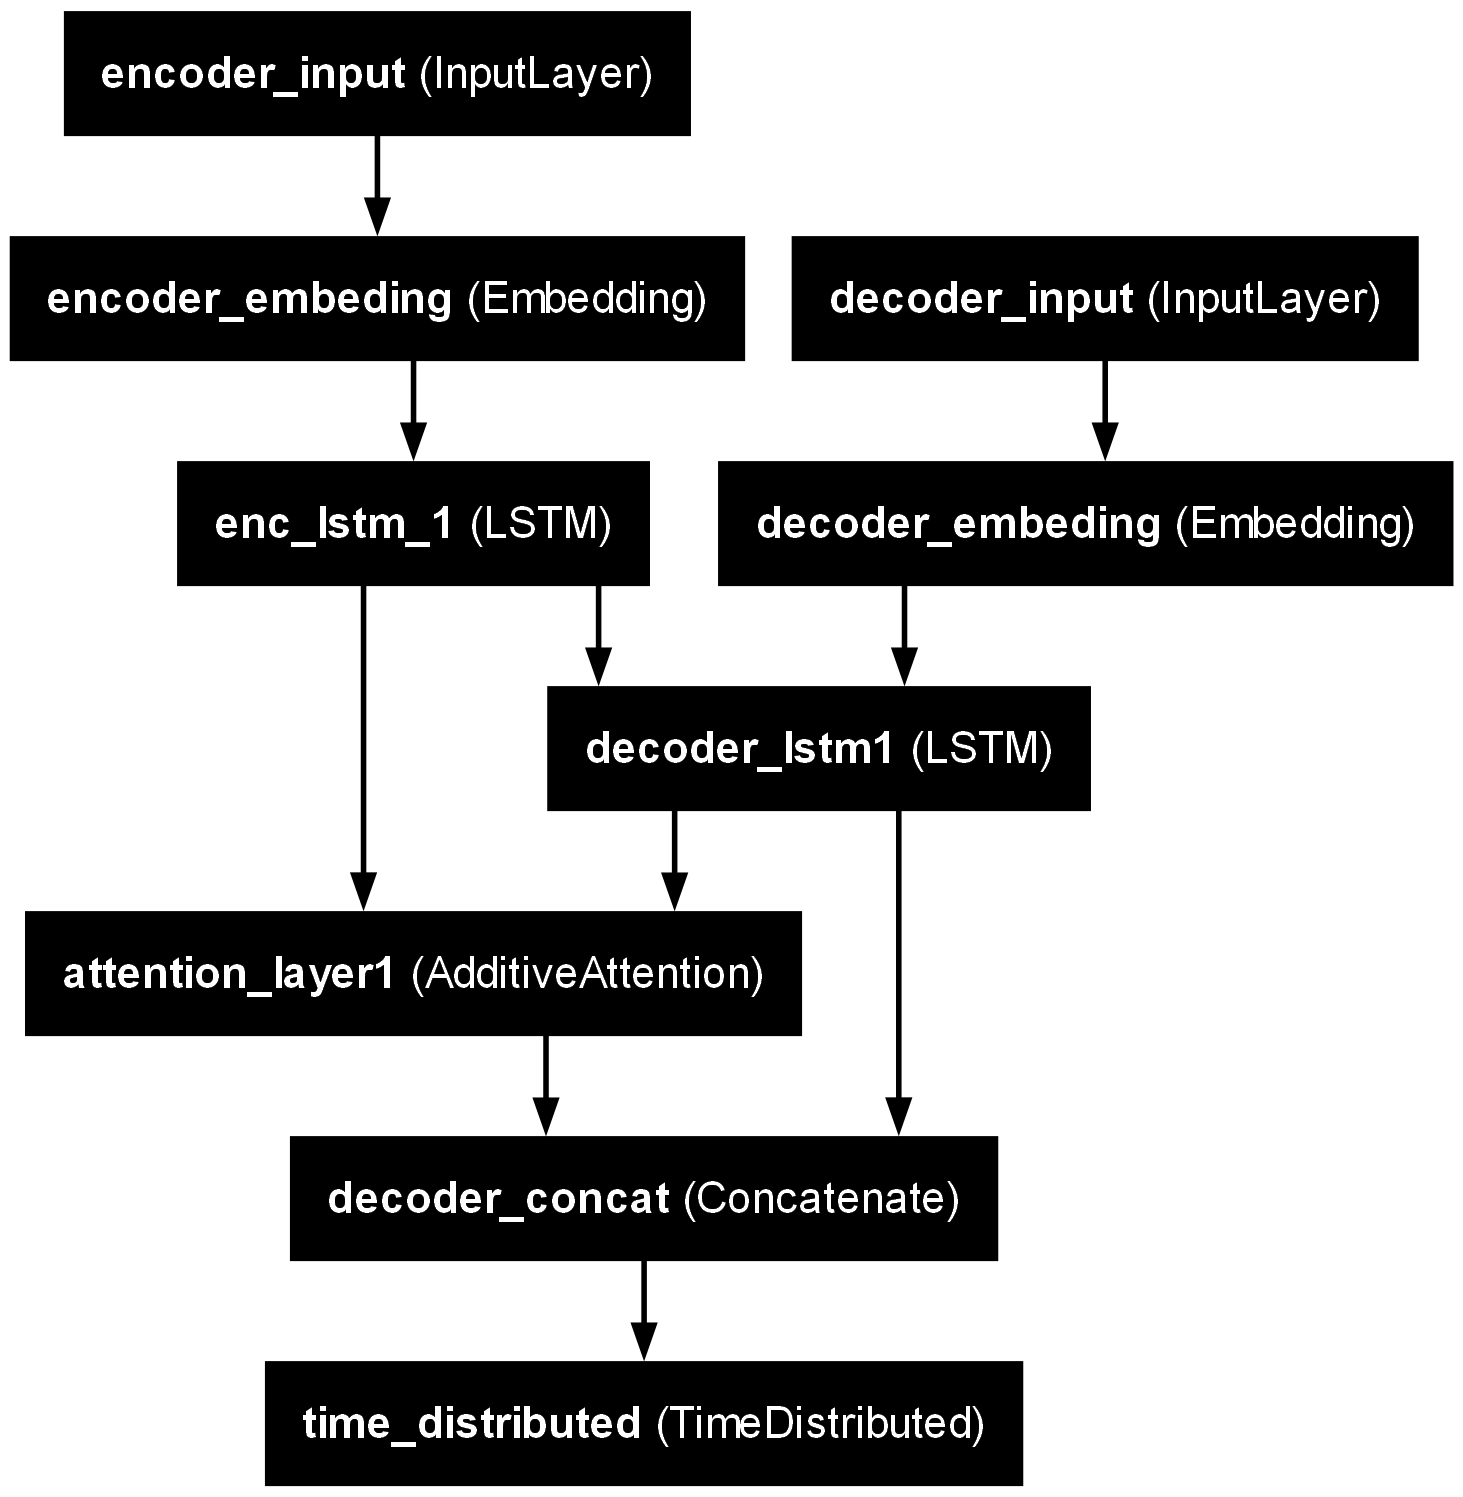

In [11]:
train_model, encoder_model, decoder_model = define_simple_model(x_tokenizer.num_words+1, y_tokenizer.num_words+1)
train_model.summary()
tf.keras.utils.plot_model(train_model, show_shapes=False, show_layer_names=True)

In [12]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint("001textsum.weights.h5", monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', mode='max', verbose=1, factor=0.8, patience=5, min_lr=0.00001)
history = train_model.fit(x_train_for_model_training, y_train_for_model_training,
                          validation_data=(x_val_for_model_training, y_val_for_model_training),
                          batch_size=256, epochs=200, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.1698 - loss: 6.1768
Epoch 1: val_accuracy improved from -inf to 0.45285, saving model to 001textsum.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.1828 - loss: 6.0547 - val_accuracy: 0.4528 - val_loss: 3.1214 - learning_rate: 0.0200
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3807 - loss: 3.8947
Epoch 2: val_accuracy improved from 0.45285 to 0.55285, saving model to 001textsum.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.3845 - loss: 3.8896 - val_accuracy: 0.5528 - val_loss: 2.8058 - learning_rate: 0.0200
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.4238 - loss: 3.6116
Epoch 3: val_accuracy improved from 0.55285 to 0.56994, saving model to 001textsum.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.4249 - loss: 3.6063 - val_accuracy: 0.5699 - val_loss: 2.6681 - learning_rate: 0.0200
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/ste

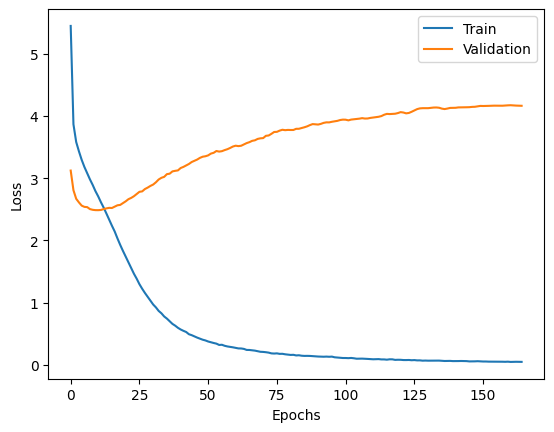

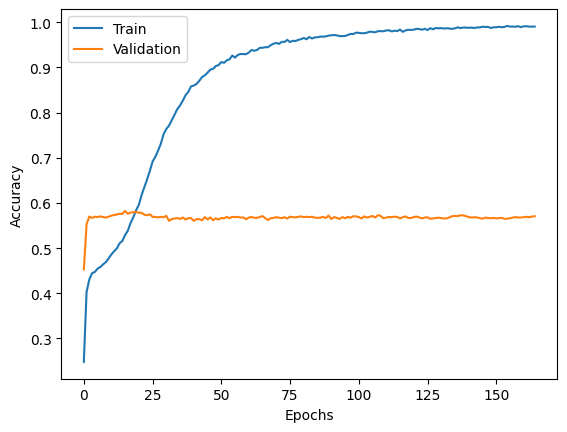

In [16]:
# plot changes of loss and accuracy over epochs
epochs_range = np.arange(len(history.history['loss']))
plt.plot(epochs_range, history.history['loss'], label='Train')
plt.plot(epochs_range, history.history['val_loss'], label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(epochs_range, history.history['accuracy'], label='Train')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
# this function receives an `input_text' and summarizes it using the previously trained encoder and decoder models.
def text_summarizer(input_text: str):
    # convert text to sequence.
    input_sequence = np.array(x_tokenizer.texts_to_sequences([input_text])).reshape((1,-1))
    # encode the input sequence
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=0)
    # Define new_token as "soseq". this means that the decoder model must start generating words.
    new_token = np.zeros((1, 1))
    new_token[0, 0] = y_tokenizer.word_index["soseq"]

    # define variables for the summary and for when to stop generating output
    summary = ""

    while True:
        # give the new_token and the last states of the LSTM cell as input to the decoder model
        # the decoder outputs the next prediction in the sequence.
        output_token, h, c = decoder_model.predict([new_token, encoder_output, encoder_h, encoder_c], verbose=0)
        output_token = np.argmax(output_token[0, -1, :]) # find the index of the most probable token

        # update the new_token
        new_token[0, 0] = output_token

        # Update internal states
        encoder_h, encoder_c = h, c
        
        # check if the output_token is 0 or the number of words in the summary exceed certain value, set the predicted_word to "eoseq"; which means stopping the decoder.
        if output_token == 0 or len(summary.split()) > MAX_SUMMARY_LEN:
            predicted_word = "eoseq"
        else:
            predicted_word = y_tokenizer.index_word[output_token] # convert token to word

        # if the predicted_word was not end of sequence, continue and add the predicted_word to the summary.
        if  predicted_word != "eoseq":
            summary += " " + predicted_word

        # if we've reached eoseq word, stop the summarization and return the summary
        if predicted_word == "eoseq":
            break

    return summary

In [37]:
# generate some summarizations by our trained model.
for i in range(16):
    print(f"_____Text {i}_____\n", x_train[i])
    print("\n_____Original summary_____\n", y_train[i][6:-6])
    print("\n_____Predicted summary_____\n", text_summarizer(x_train[i]))
    print("\n\n")

_____Text 0_____
 iker: :)
iker: oh
mike: ??
iker: i was sending that to someone else. sorry

_____Original summary_____
 iker sent mike something by mistake.

_____Predicted summary_____
  sent mike something by



_____Text 1_____
 julia: adam, are you coming today?
julia: adam, you are already an hour late, let me know asap
kate: he texted me before that he is not feeling very well
julia: thanks
adam: i had an appointment, sorry, but i have a stomach flu

_____Original summary_____
 adam has a stomach flu. 

_____Predicted summary_____
  adam has no



_____Text 2_____
 thorne: what time ru commin?
sylvester: i leave the office @5 so 6/6.30
selvyn: i gueess 7 is doable
thorne: oh right. i am out till 6 so we are fine to meet then

_____Original summary_____
 sylvester and selvyn will meet thorne around 7.

_____Predicted summary_____
  and will meet around 7



_____Text 3_____
 eva: <file_photo> 
ian: is that your dog?
eva: yes
ian: aw cutie 

_____Original summary_____
 ian thinks